# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [2]:
# ! sudo pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
# import os
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
#     !bash ../xvfb start
#     %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


### Experiment setup
* Here we simply load the game and check that it works

In [8]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:20:38,677] Making new env: LunarLander-v2


In [9]:
# plt.imshow(env.render("rgb_array"))
# del env

# Neural Network body

In [10]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)


nn = DenseLayer(observation_layer, 200, nonlinearity=elu)
nn = DenseLayer(nn, 200, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn,num_units=n_actions,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [11]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [12]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)

In [13]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [14]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:20:44,139] Making new env: LunarLander-v2


In [15]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[3 3 3 3 0]]
rewards: [[ 1.19398709  1.33668181  0.2964183  -0.4319901   0.        ]]
CPU times: user 13.5 ms, sys: 3.42 ms, total: 16.9 ms
Wall time: 35.8 ms


In [16]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [17]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [18]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.8,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [19]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [20]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
# untrained_reward = pool.evaluate(save_path="./records",record_video=True)

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [23]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = +20

In [24]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!


  1%|          | 99/10000 [00:18<24:02,  6.86it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:28:56,106] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:28:56,118] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 125 timesteps with reward=-88.70662066621567
Episode finished after 78 timesteps with reward=-313.2788494881552
Episode finished after 104 timesteps with reward=-392.7823684841747

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:28:56,379] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
  2%|▏         | 199/10000 [00:31<22:16,  7.33it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:29:09,083] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:29:09,094] Clearing 2 monitor files from previous run (because force=True was provided)



iter=100	epsilon=0.910
Current score(mean over 3) = -264.923
Episode finished after 133 timesteps with reward=-145.98087255748004
Episode finished after 120 timesteps with reward=-195.6009898015193
Episode finished after 109 timesteps with reward=-103.76521889922466

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:29:09,483] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
  3%|▎         | 299/10000 [00:46<20:06,  8.04it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:29:24,210] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:29:24,223] Clearing 2 monitor files from previous run (because force=True was provided)



iter=200	epsilon=0.828
Current score(mean over 3) = -148.449
Episode finished after 142 timesteps with reward=-301.18721795035447
Episode finished after 151 timesteps with reward=-221.85428846370638
Episode finished after 105 timesteps with reward=-400.8184015623403

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:29:24,865] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
  4%|▍         | 399/10000 [01:02<23:07,  6.92it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:29:40,719] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:29:40,730] Clearing 2 monitor files from previous run (because force=True was provided)



iter=300	epsilon=0.754
Current score(mean over 3) = -307.953
Episode finished after 180 timesteps with reward=-282.23212073592265
Episode finished after 90 timesteps with reward=-130.1031978763137
Episode finished after 115 timesteps with reward=-213.74051675815355

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:29:41,019] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
  5%|▍         | 499/10000 [01:14<16:55,  9.36it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:29:52,007] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:29:52,020] Clearing 2 monitor files from previous run (because force=True was provided)



iter=400	epsilon=0.687
Current score(mean over 3) = -208.692
Episode finished after 124 timesteps with reward=-277.0181560674348
Episode finished after 72 timesteps with reward=-98.98792596289321
Episode finished after 103 timesteps with reward=-197.76229199671712

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:29:52,212] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
  6%|▌         | 599/10000 [01:31<20:25,  7.67it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:30:09,649] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:30:09,678] Clearing 2 monitor files from previous run (because force=True was provided)



iter=500	epsilon=0.626
Current score(mean over 3) = -191.256
Episode finished after 174 timesteps with reward=-183.05261959854747
Episode finished after 101 timesteps with reward=-109.91371435105816
Episode finished after 300 timesteps with reward=-361.80096253589545

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:30:11,367] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
  7%|▋         | 699/10000 [01:48<16:51,  9.20it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:30:26,593] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:30:26,604] Clearing 2 monitor files from previous run (because force=True was provided)



iter=600	epsilon=0.571
Current score(mean over 3) = -218.256
Episode finished after 209 timesteps with reward=-185.92880730350907
Episode finished after 245 timesteps with reward=-67.57555989305652
Episode finished after 109 timesteps with reward=-161.0608798700115

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:30:27,068] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
  8%|▊         | 799/10000 [02:00<16:49,  9.12it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:30:38,268] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:30:38,279] Clearing 2 monitor files from previous run (because force=True was provided)



iter=700	epsilon=0.522
Current score(mean over 3) = -138.188
Episode finished after 288 timesteps with reward=-69.4573730336044
Episode finished after 85 timesteps with reward=-109.33435172496496
Episode finished after 197 timesteps with reward=-185.1964502340478

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:30:38,707] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
  9%|▉         | 899/10000 [02:14<21:59,  6.89it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:30:51,957] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:30:51,973] Clearing 2 monitor files from previous run (because force=True was provided)



iter=800	epsilon=0.477
Current score(mean over 3) = -121.329
Episode finished after 213 timesteps with reward=-97.80983611197534
Episode finished after 350 timesteps with reward=-251.5096757026163
Episode finished after 1000 timesteps with reward=14.807460905535006

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:30:55,719] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 10%|▉         | 999/10000 [02:33<24:01,  6.24it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:31:11,383] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:31:11,400] Clearing 2 monitor files from previous run (because force=True was provided)



iter=900	epsilon=0.436
Current score(mean over 3) = -111.504
Episode finished after 128 timesteps with reward=-98.85379024063208
Episode finished after 236 timesteps with reward=-246.63543090075916
Episode finished after 378 timesteps with reward=-198.33634667667604

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:31:12,672] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 11%|█         | 1099/10000 [02:53<21:07,  7.03it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:31:30,937] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:31:30,949] Clearing 2 monitor files from previous run (because force=True was provided)



iter=1000	epsilon=0.399
Current score(mean over 3) = -181.275
Episode finished after 271 timesteps with reward=-172.3358117755581
Episode finished after 308 timesteps with reward=-146.82736457574003
Episode finished after 386 timesteps with reward=-102.12510312950316

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:31:32,253] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 12%|█▏        | 1199/10000 [03:09<41:55,  3.50it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:31:47,000] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:31:47,011] Clearing 2 monitor files from previous run (because force=True was provided)



iter=1100	epsilon=0.366
Current score(mean over 3) = -140.429
Episode finished after 591 timesteps with reward=-210.39203011545038
Episode finished after 210 timesteps with reward=-79.30519368976731
Episode finished after 233 timesteps with reward=-95.60271602351446

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:31:50,605] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 13%|█▎        | 1299/10000 [03:29<27:40,  5.24it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:32:07,432] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:32:07,443] Clearing 2 monitor files from previous run (because force=True was provided)



iter=1200	epsilon=0.336
Current score(mean over 3) = -128.433
Episode finished after 396 timesteps with reward=-111.60304945208864
Episode finished after 466 timesteps with reward=-31.927833481931103
Episode finished after 497 timesteps with reward=-123.66926349699733

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:32:09,607] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 14%|█▍        | 1399/10000 [03:48<20:03,  7.15it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:32:26,612] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:32:26,632] Clearing 2 monitor files from previous run (because force=True was provided)



iter=1300	epsilon=0.309
Current score(mean over 3) = -89.067
Episode finished after 428 timesteps with reward=-165.59845521877088
Episode finished after 392 timesteps with reward=-152.41037320304815
Episode finished after 330 timesteps with reward=-153.35824353429444

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:32:28,521] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 15%|█▍        | 1499/10000 [04:08<26:27,  5.36it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:32:45,934] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:32:45,948] Clearing 2 monitor files from previous run (because force=True was provided)



iter=1400	epsilon=0.284
Current score(mean over 3) = -157.122
Episode finished after 432 timesteps with reward=-85.12628838074994
Episode finished after 318 timesteps with reward=-79.77455906102094
Episode finished after 402 timesteps with reward=-340.2320775518556

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:32:48,752] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 16%|█▌        | 1599/10000 [04:26<17:49,  7.86it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:33:04,541] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:33:04,562] Clearing 2 monitor files from previous run (because force=True was provided)



iter=1500	epsilon=0.262
Current score(mean over 3) = -168.378
Episode finished after 267 timesteps with reward=-114.11943898172635
Episode finished after 352 timesteps with reward=-97.33345704796452
Episode finished after 412 timesteps with reward=-270.8146239935685

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:33:05,754] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 17%|█▋        | 1699/10000 [04:43<27:57,  4.95it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:33:21,772] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:33:21,784] Clearing 2 monitor files from previous run (because force=True was provided)



iter=1600	epsilon=0.242
Current score(mean over 3) = -160.756
Episode finished after 199 timesteps with reward=-114.74804869092337
Episode finished after 382 timesteps with reward=-129.4529653224949
Episode finished after 382 timesteps with reward=-232.48188231070037

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:33:23,030] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 18%|█▊        | 1799/10000 [04:59<21:40,  6.30it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:33:37,392] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:33:37,403] Clearing 2 monitor files from previous run (because force=True was provided)



iter=1700	epsilon=0.224
Current score(mean over 3) = -158.894
Episode finished after 724 timesteps with reward=-309.27747590849367
Episode finished after 424 timesteps with reward=-184.6171526682918
Episode finished after 315 timesteps with reward=-169.0733781873438

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:33:39,634] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 19%|█▉        | 1899/10000 [05:15<15:25,  8.75it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:33:52,875] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:33:52,887] Clearing 2 monitor files from previous run (because force=True was provided)



iter=1800	epsilon=0.207
Current score(mean over 3) = -220.989
Episode finished after 254 timesteps with reward=-14.34291003438834
Episode finished after 252 timesteps with reward=-286.7954963712695
Episode finished after 170 timesteps with reward=-87.11751369308104

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:33:53,488] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 20%|█▉        | 1999/10000 [05:28<15:53,  8.39it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:34:06,271] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:34:06,283] Clearing 2 monitor files from previous run (because force=True was provided)



iter=1900	epsilon=0.192
Current score(mean over 3) = -129.419
Episode finished after 221 timesteps with reward=-63.37127959354876
Episode finished after 457 timesteps with reward=-219.97990716821758
Episode finished after 188 timesteps with reward=-233.63707888869578

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:34:07,213] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 21%|██        | 2099/10000 [05:42<15:41,  8.40it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:34:20,553] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:34:20,563] Clearing 2 monitor files from previous run (because force=True was provided)



iter=2000	epsilon=0.179
Current score(mean over 3) = -172.329
Episode finished after 354 timesteps with reward=-196.94512133740886
Episode finished after 347 timesteps with reward=-262.7786691280447
Episode finished after 263 timesteps with reward=-294.1806086927298

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:34:21,626] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 22%|██▏       | 2199/10000 [05:56<14:59,  8.67it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:34:34,156] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:34:34,167] Clearing 2 monitor files from previous run (because force=True was provided)



iter=2100	epsilon=0.166
Current score(mean over 3) = -251.301
Episode finished after 310 timesteps with reward=-147.33787386872575
Episode finished after 392 timesteps with reward=-158.90887605691213
Episode finished after 375 timesteps with reward=-114.51723327568466

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:34:35,349] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 23%|██▎       | 2299/10000 [06:10<15:35,  8.23it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:34:48,442] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:34:48,452] Clearing 2 monitor files from previous run (because force=True was provided)



iter=2200	epsilon=0.155
Current score(mean over 3) = -140.255
Episode finished after 369 timesteps with reward=-96.17838804794025
Episode finished after 588 timesteps with reward=81.7315957762558
Episode finished after 255 timesteps with reward=-277.023297239469

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:34:50,481] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 24%|██▍       | 2399/10000 [06:25<15:05,  8.39it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:35:02,954] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:35:02,967] Clearing 2 monitor files from previous run (because force=True was provided)



iter=2300	epsilon=0.145
Current score(mean over 3) = -97.157
Episode finished after 383 timesteps with reward=-341.18372347812186
Episode finished after 298 timesteps with reward=-104.3649915252671
Episode finished after 213 timesteps with reward=-151.6924184095941

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:35:04,112] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 25%|██▍       | 2499/10000 [06:39<14:12,  8.80it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:35:16,949] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:35:16,960] Clearing 2 monitor files from previous run (because force=True was provided)



iter=2400	epsilon=0.136
Current score(mean over 3) = -199.080
Episode finished after 316 timesteps with reward=-94.69266932214411
Episode finished after 441 timesteps with reward=-271.3604311386123
Episode finished after 727 timesteps with reward=39.58586593053322

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:35:19,320] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 26%|██▌       | 2599/10000 [06:55<16:04,  7.68it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:35:33,069] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:35:33,080] Clearing 2 monitor files from previous run (because force=True was provided)



iter=2500	epsilon=0.128
Current score(mean over 3) = -108.822
Episode finished after 345 timesteps with reward=-238.11226155682337
Episode finished after 274 timesteps with reward=-112.77862404572238
Episode finished after 658 timesteps with reward=200.54126786621416

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:35:35,248] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 27%|██▋       | 2699/10000 [07:11<14:02,  8.67it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:35:49,214] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:35:49,224] Clearing 2 monitor files from previous run (because force=True was provided)



iter=2600	epsilon=0.121
Current score(mean over 3) = -50.117
Episode finished after 972 timesteps with reward=102.67321713495816
Episode finished after 265 timesteps with reward=-263.8831524512043
Episode finished after 897 timesteps with reward=92.97627548143174

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:35:53,169] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 28%|██▊       | 2799/10000 [07:32<17:38,  6.80it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:36:10,284] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:36:10,295] Clearing 2 monitor files from previous run (because force=True was provided)



iter=2700	epsilon=0.114
Current score(mean over 3) = -22.745
Episode finished after 579 timesteps with reward=182.51965641239653
Episode finished after 511 timesteps with reward=-336.44424197326487
Episode finished after 409 timesteps with reward=-260.70978602494375

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:36:12,548] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 29%|██▉       | 2899/10000 [07:51<19:31,  6.06it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:36:28,834] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:36:28,845] Clearing 2 monitor files from previous run (because force=True was provided)



iter=2800	epsilon=0.108
Current score(mean over 3) = -138.211
Episode finished after 569 timesteps with reward=-147.14737759400322
Episode finished after 638 timesteps with reward=-176.06853568318348
Episode finished after 866 timesteps with reward=118.43702201614285

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:36:33,459] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 30%|██▉       | 2999/10000 [08:10<19:36,  5.95it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:36:48,689] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:36:48,701] Clearing 2 monitor files from previous run (because force=True was provided)



iter=2900	epsilon=0.102
Current score(mean over 3) = -68.260
Episode finished after 490 timesteps with reward=-162.92672846450216
Episode finished after 485 timesteps with reward=-144.58844982468705
Episode finished after 296 timesteps with reward=-88.38321773442354

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:36:50,433] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 31%|███       | 3099/10000 [08:27<19:00,  6.05it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:37:05,761] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:37:05,772] Clearing 2 monitor files from previous run (because force=True was provided)



iter=3000	epsilon=0.097
Current score(mean over 3) = -131.966
Episode finished after 502 timesteps with reward=-141.41036075690988
Episode finished after 853 timesteps with reward=20.502647390188244
Episode finished after 306 timesteps with reward=-265.0096136142157

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:37:08,820] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 32%|███▏      | 3199/10000 [08:46<16:33,  6.84it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:37:24,197] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:37:24,208] Clearing 2 monitor files from previous run (because force=True was provided)



iter=3100	epsilon=0.093
Current score(mean over 3) = -128.639
Episode finished after 521 timesteps with reward=-321.24551870039323
Episode finished after 820 timesteps with reward=130.97419023611127
Episode finished after 405 timesteps with reward=-277.5022402768647

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:37:27,786] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 33%|███▎      | 3299/10000 [09:07<14:05,  7.93it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:37:45,455] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:37:45,467] Clearing 2 monitor files from previous run (because force=True was provided)



iter=3200	epsilon=0.089
Current score(mean over 3) = -155.925
Episode finished after 945 timesteps with reward=-479.4817682452423
Episode finished after 660 timesteps with reward=125.85041939748227
Episode finished after 738 timesteps with reward=-111.29974724763716

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:37:51,159] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
 34%|███▍      | 3399/10000 [09:31<20:49,  5.28it/s]INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:38:09,150] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:38:09,162] Clearing 2 monitor files from previous run (because force=True was provided)



iter=3300	epsilon=0.085
Current score(mean over 3) = -154.977
Episode finished after 590 timesteps with reward=130.43961868478812
Episode finished after 843 timesteps with reward=26.78606470493358
Episode finished after 829 timesteps with reward=39.23272207877889

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')
[2017-11-04 19:38:13,492] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records')



iter=3400	epsilon=0.082
Current score(mean over 3) = 65.486
You win!


/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


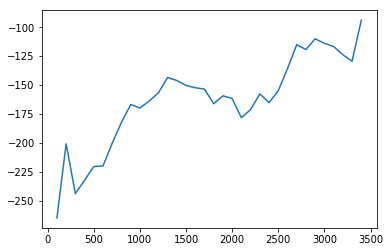

In [31]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda k:k[0]))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [32]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

INFO:gym.envs.registration:Making new env: LunarLander-v2
[2017-11-04 19:57:26,631] Making new env: LunarLander-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:57:26,643] Clearing 2 monitor files from previous run (because force=True was provided)
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records/openaigym.video.62.55921.video000000.mp4
[2017-11-04 19:57:26,648] Starting new video recorder writing to /Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW5(RL)/records/openaigym.video.62.55921.video000000.mp4


DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.